# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.functions import isnan, when, count, col,isnull,avg
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType


from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler


from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression


import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import barplot,countplot


from pyspark.sql.functions import percent_rank
from pyspark.sql import Window


from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics


from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression



In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("ZeizerChurnProject") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

# Loading the data

In [3]:
path = "mini_sparkify_event_data.json"
data_churn = spark.read.json(path)

# Cleaning the data

In [4]:
data_churn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
data_churn.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
data_churn.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

# Number of lines and Columns

In [7]:
print(data_churn.count(),len(data_churn.columns))

286500 18


### tem o DropDuplicates


# Searching for NaN's
### from: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

In [8]:
data_churn.select([count(when(isnan(c), c)).alias(c) for c in data_churn.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [9]:
data_churn.select([count(when(isnull(c), c)).alias(c) for c in data_churn.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [10]:
data_churn.select(['artist','length','song']).collect()

[Row(artist='Martha Tilston', length=277.89016, song='Rockpools'),
 Row(artist='Five Iron Frenzy', length=236.09424, song='Canada'),
 Row(artist='Adam Lambert', length=282.8273, song='Time For Miracles'),
 Row(artist='Enigma', length=262.71302, song='Knocking On Forbidden Doors'),
 Row(artist='Daft Punk', length=223.60771, song='Harder Better Faster Stronger'),
 Row(artist='The All-American Rejects', length=208.29995, song="Don't Leave Me"),
 Row(artist='The Velvet Underground / Nico', length=260.46649, song='Run Run Run'),
 Row(artist='Starflyer 59', length=185.44281, song='Passengers (Old Album Version)'),
 Row(artist=None, length=None, song=None),
 Row(artist='Frumpies', length=134.47791, song='Fuck Kitty'),
 Row(artist='Britt Nicole', length=229.8771, song='Walk On The Water'),
 Row(artist=None, length=None, song=None),
 Row(artist='Edward Sharpe & The Magnetic Zeros', length=223.58159, song='Jade'),
 Row(artist='Tesla', length=201.06404, song="Gettin' Better"),
 Row(artist=None, l

In [11]:
avg_len=data_churn.agg(avg('length')).take(1)[0][0]

In [12]:
to_replace='missing_val'

In [13]:
data_churn=data_churn.fillna(to_replace,subset=['artist','song'])

In [14]:
data_churn=data_churn.fillna(avg_len,subset=['length'])

In [15]:
data_churn.select([count(when(isnull(c), c)).alias(c) for c in data_churn.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|     8346|  8346|            0|    8346|     0|    0|    8346|     0|   0|        8346|        0|   0|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



# Let us drop the remainder rows with NaN's

In [16]:
to_replace2='missing_val2'

In [17]:
data_churn=data_churn.fillna(to_replace2,subset=['firstName','gender','lastName','location','userAgent'])

In [18]:
data_churn.select([count(when(isnull(c), c)).alias(c) for c in data_churn.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|        8346|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [19]:
data_churn.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [20]:
#data_churn.select('registration').collect()
avg_reg=int(data_churn.agg(avg('registration')).take(1)[0][0])
print(avg_reg)

1535358834084


In [21]:
data_churn=data_churn.fillna(avg_reg,subset=['registration'])

In [22]:
data_churn.select([count(when(isnull(c), c)).alias(c) for c in data_churn.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [23]:
flag_churn_event = udf(lambda x: 1 if (x == "Submit Downgrade" or x=='Downgrade' or x=='Cancellation Confirmation' or x=='Cancel') else 0, IntegerType())

# Creating the churn variable

In [24]:
data_churn = data_churn.withColumn("churn", flag_churn_event("page"))

In [25]:
data_churn.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', churn=0)]

In [26]:
data_churn.select('churn').distinct().collect()

[Row(churn=1), Row(churn=0)]

# Creating the hour variable

In [27]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 3600.0). hour)

In [28]:
data_churn = data_churn.withColumn("hour", get_hour(data_churn.ts))

In [29]:
data_churn.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|churn|hour|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|  20|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [30]:
data_churn.select(['page']).distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [31]:
data_churn.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn',
 'hour']

In [32]:
data_churn.select(['userId','page']).distinct().collect()

[Row(userId='88', page='Home'),
 Row(userId='88', page='NextSong'),
 Row(userId='13', page='Add to Playlist'),
 Row(userId='87', page='Home'),
 Row(userId='131', page='Upgrade'),
 Row(userId='59', page='Add Friend'),
 Row(userId='40', page='Help'),
 Row(userId='92', page='Settings'),
 Row(userId='12', page='Thumbs Up'),
 Row(userId='50', page='Error'),
 Row(userId='81', page='Upgrade'),
 Row(userId='81', page='Submit Upgrade'),
 Row(userId='53', page='Submit Upgrade'),
 Row(userId='99', page='Downgrade'),
 Row(userId='200017', page='NextSong'),
 Row(userId='300015', page='Add Friend'),
 Row(userId='300007', page='Roll Advert'),
 Row(userId='300005', page='Thumbs Up'),
 Row(userId='300014', page='Downgrade'),
 Row(userId='300019', page='Upgrade'),
 Row(userId='300002', page='Help'),
 Row(userId='300019', page='About'),
 Row(userId='131', page='Help'),
 Row(userId='88', page='Thumbs Up'),
 Row(userId='122', page='Home'),
 Row(userId='93', page='Upgrade'),
 Row(userId='4', page='Add Frien

# Writting in Pandas

In [33]:
churn_pd=data_churn.toPandas()

# There are no NaN's

In [34]:
churn_pd.isna().sum()

artist           0
auth             0
firstName        0
gender           0
itemInSession    0
lastName         0
length           0
level            0
location         0
method           0
page             0
registration     0
sessionId        0
song             0
status           0
ts               0
userAgent        0
userId           0
churn            0
hour             0
dtype: int64

In [35]:
churn_pd.isnull().sum()

artist           0
auth             0
firstName        0
gender           0
itemInSession    0
lastName         0
length           0
level            0
location         0
method           0
page             0
registration     0
sessionId        0
song             0
status           0
ts               0
userAgent        0
userId           0
churn            0
hour             0
dtype: int64

# There are no duplicates

In [36]:
churn_pd.duplicated().sum()

0

In [37]:
churn_pd.shape

(286500, 20)

In [38]:
df=churn_pd.copy()

In [39]:
#df.dropna(inplace=True)

In [40]:
df.isna().sum()

artist           0
auth             0
firstName        0
gender           0
itemInSession    0
lastName         0
length           0
level            0
location         0
method           0
page             0
registration     0
sessionId        0
song             0
status           0
ts               0
userAgent        0
userId           0
churn            0
hour             0
dtype: int64

In [41]:
df.duplicated().sum()

0

# Churn Imbalance

In [42]:
df['churn'].value_counts()

0    284278
1      2222
Name: churn, dtype: int64

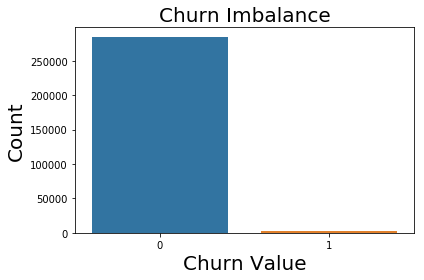

In [43]:
import seaborn as sns
from seaborn import barplot
#plt.hist(df['churn'].value_counts())
sns.countplot(x="churn",data=df)
plt.title('Churn Imbalance',size=20)
plt.xlabel('Churn Value',size=20)
plt.ylabel('Count',size=20)
plt.tight_layout()
plt.savefig('churn_imbalance.jpeg')
plt.show()

# Creating the churn dataframe

In [44]:
df_churn=df[df['churn']==1]#['hour'].hist(bins=20);
df_churn

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,hour
35,missing_val,Logged In,Alexi,F,4,Warren,249.117182,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1532482662000,53,missing_val,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,1,20
357,missing_val,Logged In,Faigy,F,29,Howe,249.117182,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Downgrade,1538211832000,248,missing_val,200,1538373286000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,95,1,21
879,missing_val,Logged In,Faigy,F,115,Howe,249.117182,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Downgrade,1538211832000,248,missing_val,200,1538392612000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,95,1,23
929,missing_val,Logged In,Kael,M,46,Baker,249.117182,paid,"Kingsport-Bristol-Bristol, TN-VA",GET,Downgrade,1533102330000,249,missing_val,200,1538393618000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,1,23
930,missing_val,Logged In,Kael,M,47,Baker,249.117182,paid,"Kingsport-Bristol-Bristol, TN-VA",PUT,Submit Downgrade,1533102330000,249,missing_val,307,1538393619000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,1,23
932,missing_val,Logged In,Faigy,F,125,Howe,249.117182,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Downgrade,1538211832000,248,missing_val,200,1538393664000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,95,1,23
984,missing_val,Logged In,Grant,M,119,Flores,249.117182,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Downgrade,1538120859000,141,missing_val,200,1538394855000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",142,1,23
993,missing_val,Logged In,Grant,M,121,Flores,249.117182,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Downgrade,1538120859000,141,missing_val,200,1538395054000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",142,1,23
1079,missing_val,Logged In,Elizabeth,F,17,Washington,249.117182,paid,"Oklahoma City, OK",GET,Downgrade,1532472246000,247,missing_val,200,1538396771000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",120,1,23
1149,missing_val,Logged In,Panav,M,41,Myers,249.117182,paid,"Morgantown, WV",GET,Downgrade,1538239045000,237,missing_val,200,1538398230000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",15,1,23


# Histogram of Churns by hour

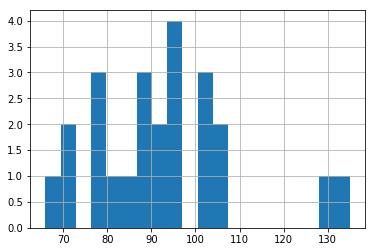

In [46]:
df_churn['hour'].value_counts().hist(bins=20)
plt.show()

# Churn Length

# The below histogram shows the length of the song for customers who churned. Interestingly, they all had the same length!! This is related to the fact that the artists and songs of customers that churned were all NaN's in the original given mini dataset.

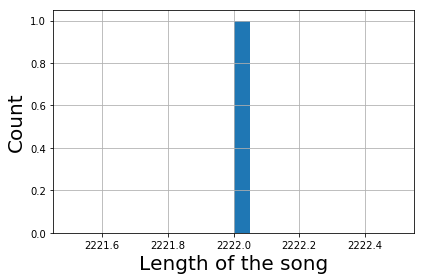

In [48]:
df_churn['length'].value_counts().hist(bins=20)
plt.ylabel('Count',size=20)
plt.xlabel('Length of the song',size=20)
plt.tight_layout()
#plt.savefig('./churn_length.jpeg')
plt.show()

In [49]:
df_churn['length'].value_counts()

249.117182    2222
Name: length, dtype: int64

# Churn by gender

In [50]:
df_churn['gender'].value_counts()

F    1207
M    1015
Name: gender, dtype: int64

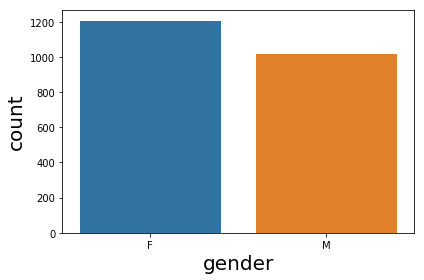

In [51]:
countplot(x='gender',data=df_churn)
plt.xlabel('gender',size=20)
plt.ylabel('count',size=20)
plt.tight_layout()
#plt.savefig('./churn_gender.jpeg')
plt.show()

# As it can be seen, more females churned than males. It seems appropriate for Sparkify to announce a discount for females in order to diminish this pronounced "female churn".

# Churn by location

In [52]:
df_churn['location'].value_counts()[:10]

#plt.tight_layout()
#plt.show()

Los Angeles-Long Beach-Anaheim, CA             226
New York-Newark-Jersey City, NY-NJ-PA          208
Boston-Cambridge-Newton, MA-NH                 127
Houston-The Woodlands-Sugar Land, TX            77
Charlotte-Concord-Gastonia, NC-SC               70
Dallas-Fort Worth-Arlington, TX                 62
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     55
Louisville/Jefferson County, KY-IN              53
Phoenix-Mesa-Scottsdale, AZ                     45
Spokane-Spokane Valley, WA                      44
Name: location, dtype: int64

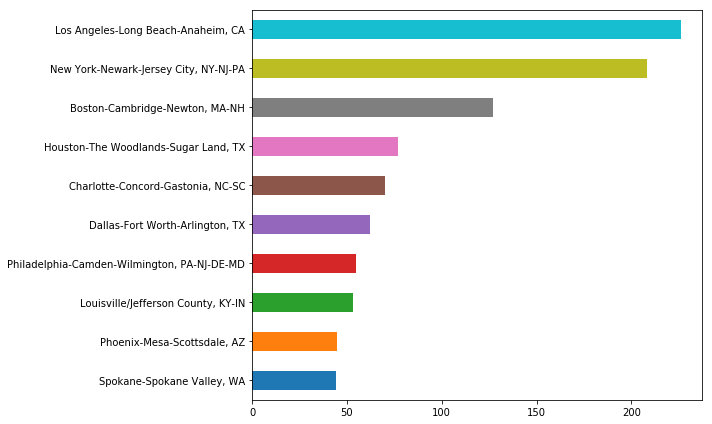

In [53]:
plt.figure(figsize=[10,6])
(df_churn['location']).value_counts()[:10].sort_values().plot(kind='barh');
plt.tight_layout()
#plt.savefig('./churn_location.jpeg')
plt.show()

# Offer a discount in the top ten place with more churn!

# From this figure, it can be seen that Los Angeles, New York, and Boston have the highest churn numbers. Therefore, it is appropriate to offer a discount for Sparkify's plans in order to minimize customer churns in these places (the best it would be to apply this discount in the top 10 places shown in the figure).

# Churn by userAgent

In [54]:
df_churn['userAgent'].nunique()

51

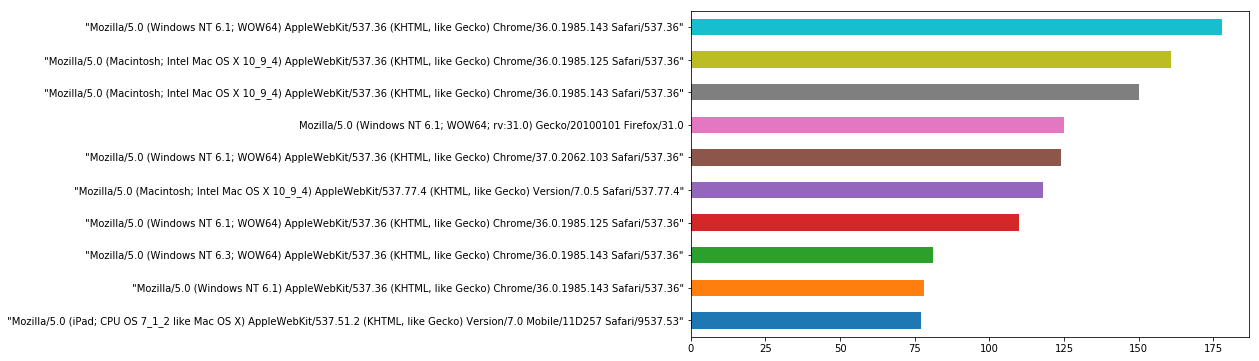

In [55]:
plt.figure(figsize=[10,6])
(df_churn['userAgent']).value_counts()[:10].sort_values().plot(kind='barh');
#plt.tight_layout()
#plt.savefig('./churn_useragent.jpeg')
plt.show()


# As previously discussed, we can work on the top 10 userAgent and try to minimize the customer churns.

In [58]:
df_churn['artist'].unique()

array(['missing_val'], dtype=object)

In [59]:
df_churn['song'].unique()

array(['missing_val'], dtype=object)

# *** as in the churn the 'song' and 'artist' columns are just the missing values, we will drop these columns

# Churn by level

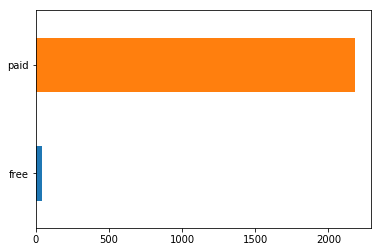

In [61]:
df_churn['level'].value_counts().sort_values().plot(kind='barh')

In [62]:
df_churn['method'].value_counts()

GET    2107
PUT     115
Name: method, dtype: int64

# The same analysis, but for customers who did not churn

In [63]:
df_nochurn=df[df['churn']==0]#['hour'].hist(bins=20);
df_nochurn

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,hour
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.890160,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,20
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.094240,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,20
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.827300,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,20
3,Enigma,Logged In,Micah,M,80,Long,262.713020,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,20
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.607710,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,20
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.299950,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,20
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.466490,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,20
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.442810,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,20
8,missing_val,Logged In,Colin,M,54,Freeman,249.117182,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,missing_val,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,20
9,Frumpies,Logged In,Colin,M,55,Freeman,134.477910,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,20


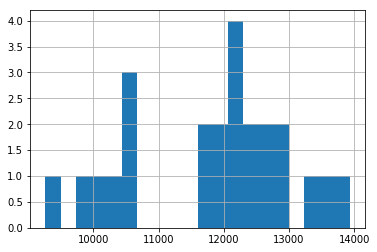

In [64]:
df_nochurn['hour'].value_counts().hist(bins=20)

In [65]:
df_nochurn['length']

0         277.890160
1         236.094240
2         282.827300
3         262.713020
4         223.607710
5         208.299950
6         260.466490
7         185.442810
8         249.117182
9         134.477910
10        229.877100
11        249.117182
12        223.581590
13        201.064040
14        249.117182
15        246.699950
16        168.646080
17        166.112200
18        222.223220
19        229.772610
20        283.741590
21        223.921180
22        250.931790
23        231.261590
24        174.419140
25        233.325260
26        216.842000
27        241.606080
28        307.460770
29        219.663220
             ...    
286470    201.377510
286471    210.886080
286472    217.651790
286473    250.827300
286474    173.766080
286475    249.117182
286476    218.409340
286477    180.740770
286478    380.682000
286479    249.117182
286480    258.794650
286481    228.283630
286482    249.117182
286483    115.904850
286484    222.562810
286485    273.945670
286486    655

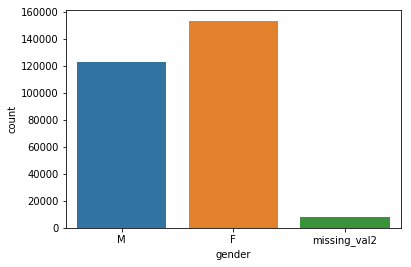

In [66]:
df_nochurn['gender'].value_counts()
countplot(x='gender',data=df_nochurn)

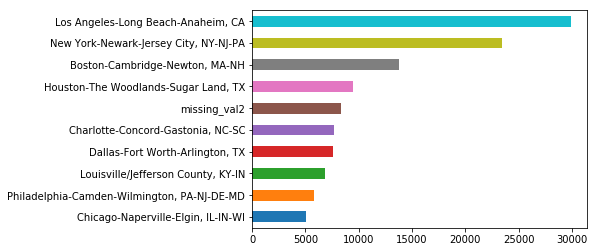

In [67]:
df_nochurn['location'].value_counts()[:10].sort_values().plot(kind='barh')

In [68]:
df_nochurn['location'].nunique()

115

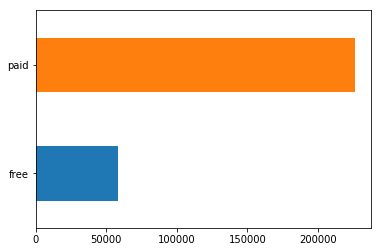

In [69]:
df_nochurn['level'].value_counts().sort_values().plot(kind='barh')

In [ ]:
# 

In [72]:
df_nochurn['method'].unique()

array(['PUT', 'GET'], dtype=object)

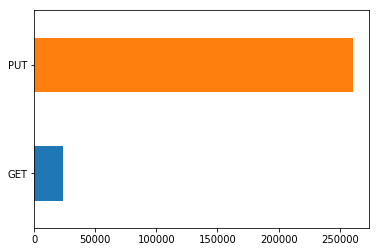

In [73]:
df_nochurn['method'].value_counts().sort_values().plot(kind='barh')

# No Churn by status

In [77]:
df_nochurn['status'].nunique()

3

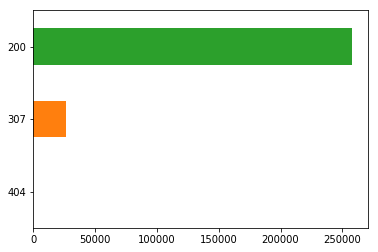

In [78]:
df_nochurn['status'].value_counts().sort_values().plot(kind='barh');

In [79]:
df_nochurn['status'].value_counts()

200    257705
307     26315
404       258
Name: status, dtype: int64

# auth not useful at all

In [80]:
df_nochurn['auth'].value_counts()

Logged In     275932
Logged Out      8249
Guest             97
Name: auth, dtype: int64

# Coming back to Churns!

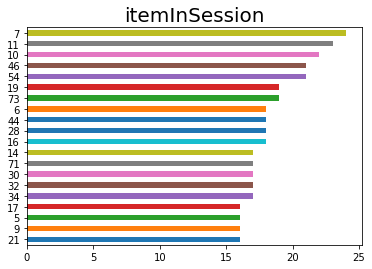

In [82]:
df_churn['itemInSession'].value_counts()[:20].sort_values().plot(kind='barh');
plt.title('itemInSession',size=20)
#plt.savefig('./churn_iteminsession.jpeg')
plt.show()

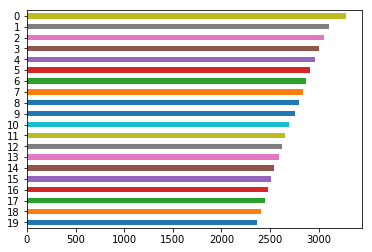

In [83]:
df_nochurn['itemInSession'].value_counts()[:20].sort_values().plot(kind='barh');

# It changes from customers who churn to customers which did not churn!!

# Temporal EDA

In [84]:
df_churn.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,hour
35,missing_val,Logged In,Alexi,F,4,Warren,249.117182,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1532482662000,53,missing_val,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,1,20
357,missing_val,Logged In,Faigy,F,29,Howe,249.117182,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Downgrade,1538211832000,248,missing_val,200,1538373286000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,95,1,21


# Let us set the initial date as 1970-01-01

In [86]:
df_churn['date']=pd.to_timedelta(df_churn['ts'],unit="ms")+ pd.Timestamp('1970-01-01')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
df_nochurn['date']=pd.to_timedelta(df_nochurn['ts'],unit="ms")+ pd.Timestamp('1970-01-01')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
df_churn.tail(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,churn,hour,date
285652,missing_val,Logged In,Joshua,M,44,White,249.117182,paid,"San Antonio-New Braunfels, TX",GET,...,1528780738000,492,missing_val,200,1543514426000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300015,1,10,2018-11-29 18:00:26
286059,missing_val,Logged In,Joshua,M,81,Warner,249.117182,paid,"San Jose-Sunnyvale-Santa Clara, CA",GET,...,1536935950000,488,missing_val,200,1543548964000,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,300025,1,13,2018-11-30 03:36:04


# Creating the column 'day'

In [89]:
df_churn['day']=df_churn.date.dt.day

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


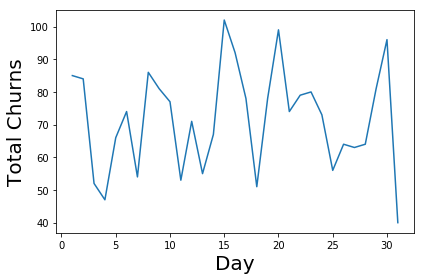

In [90]:
df_churn.groupby(['day']).sum()['churn'].plot()
plt.ylabel('Total Churns',size=20)
plt.xlabel('Day',size=20)
plt.tight_layout()
#plt.savefig('./churn_totalchurnbyday.jpeg')
plt.show()

# This time series is interesting, it has an almost well-defined pattern, with the number of total churns reaching maximums and minimums almost periodically.

# Plotting sessionId by date

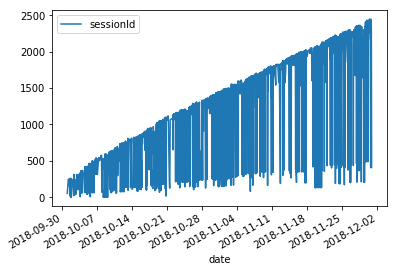

In [91]:
df_churn.plot(x='date',y='sessionId')

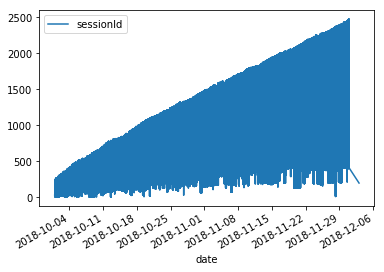

In [92]:
df_nochurn.plot(x='date',y='sessionId')

# It is ok for churn and no-churn

# Plotting itemInSession by Date

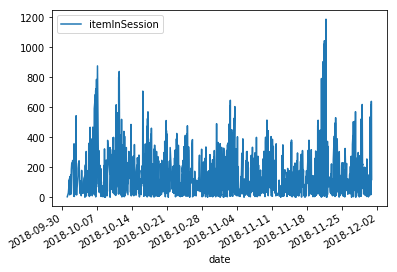

In [93]:
df_churn.plot(x='date',y='itemInSession')

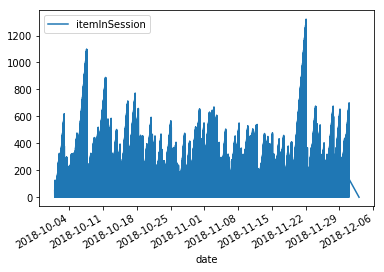

In [94]:
df_nochurn.plot(x='date',y='itemInSession')

# Seems to be ok!

# Plotting histograms of the time series

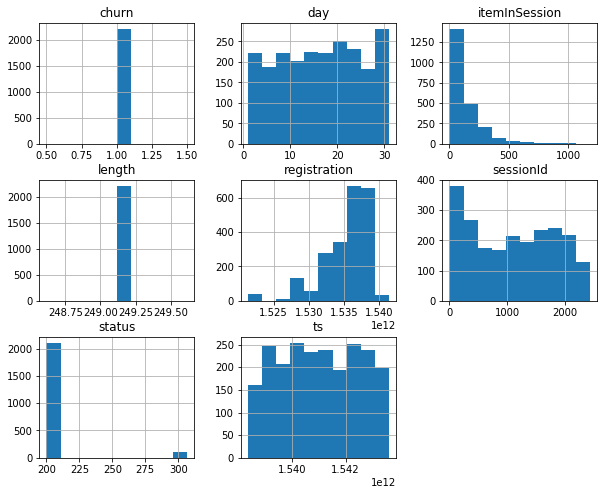

In [96]:
plt.figure()
df_churn.hist(figsize=[10,8]);
plt.show()

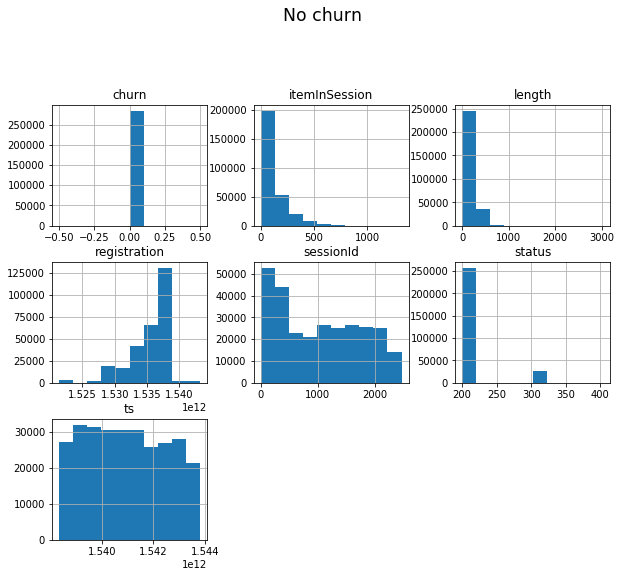

In [97]:
#plt.plot(df_nochurn[df_nochurn['gender']=='M']['date'],df_nochurn[df_nochurn['gender']=='M']['gender'])
import matplotlib.pyplot as plt
df_nochurn.hist(figsize=[10,8])
#df_churn.hist(ax=axes[1],figsize=[10,8])
plt.suptitle('No churn', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Splitting into train and test!

In [94]:
df.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,hour
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,20
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,20


In [95]:
to_drop_cols=['artist','auth','firstName','lastName','page','registration','sessionId','song','hour']

In [96]:
data_churn=data_churn.drop(*to_drop_cols)

In [97]:
data_churn.printSchema()

root
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = false)
 |-- method: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = false)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)



In [98]:
data_churn = data_churn.withColumn("userId", data_churn["userId"].cast(IntegerType()))


In [99]:
data_churn.printSchema()

root
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = false)
 |-- method: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = false)
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [100]:
num_cols=['itemInSession','length','status','ts','userId','churn']

In [101]:

data_churn = data_churn.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("ts")))
train_data = data_churn.where("rank <= .8").drop("rank")
test_data = data_churn.where("rank > .8").drop("rank")


# One hot encoder

In [102]:
stringInd_gender = StringIndexer(inputCol="gender", outputCol="gender_index",handleInvalid='skip')
#model = stringIndexer.fit(df2)
#indexed = model.transform(df2)
#encoder_gender = OneHotEncoder(dropLast=False, inputCol="gender_index", outputCol="gender_vec")
encoder_gender = OneHotEncoder(inputCol="gender_index", outputCol="gender_vec")

stringInd_level = StringIndexer(inputCol="level", outputCol="level_index",handleInvalid='skip')
#model = stringIndexer.fit(df2)
#indexed = model.transform(df2)
#encoder_level = OneHotEncoder(dropLast=False, inputCol="level_index", outputCol="level_vec")
encoder_level = OneHotEncoder(inputCol="level_index", outputCol="level_vec")

stringInd_method = StringIndexer(inputCol="method", outputCol="method_index",handleInvalid='skip')
#model = stringIndexer.fit(df2)
#indexed = model.transform(df2)
#encoder_method = OneHotEncoder(dropLast=False, inputCol="method_index", outputCol="method_vec")
encoder_method = OneHotEncoder(inputCol="method_index", outputCol="method_vec")



# Just StringIndexer

In [103]:
stringInd_location = StringIndexer(inputCol="location", outputCol="location_index",handleInvalid='skip')
#model = stringIndexer.fit(df2)
#indexed = model.transform(df2)
#encoder_location = OneHotEncoder(dropLast=False, inputCol="location_index", outputCol="location_vec")
encoder_location = OneHotEncoder(inputCol="location_index", outputCol="location_vec")

stringInd_Agent = StringIndexer(inputCol="userAgent", outputCol="userAgent_index",handleInvalid='skip')
#model = stringIndexer.fit(df2)
#indexed = model.transform(df2)
#encoder_Agent = OneHotEncoder(dropLast=False, inputCol="userAgent_index", outputCol="userAgent_vec")
encoder_Agent = OneHotEncoder(inputCol="userAgent_index", outputCol="userAgent_vec")




In [104]:
vec_assem=VectorAssembler(inputCols=['itemInSession','length','status','ts','userId',"gender_vec","level_vec",'method_vec',"location_vec","userAgent_vec"],outputCol='features',handleInvalid='skip')

In [105]:
#pipeline=Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem])

In [106]:
#train_data=pipeline.fit(train_data).transform(train_data)

In [107]:
#test_data=pipeline.fit(test_data).transform(test_data)

In [108]:
train_data.show()

+------+-------------+-----------------+-----+--------------------+------+------+-------------+--------------------+------+-----+
|gender|itemInSession|           length|level|            location|method|status|           ts|           userAgent|userId|churn|
+------+-------------+-----------------+-----+--------------------+------+------+-------------+--------------------+------+-----+
|     M|           50|        277.89016| paid|     Bakersfield, CA|   PUT|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|     M|           79|        236.09424| free|Boston-Cambridge-...|   PUT|   200|1538352180000|"Mozilla/5.0 (Win...|     9|    0|
|     M|           51|         282.8273| paid|     Bakersfield, CA|   PUT|   200|1538352394000|Mozilla/5.0 (Wind...|    30|    0|
|     M|           80|        262.71302| free|Boston-Cambridge-...|   PUT|   200|1538352416000|"Mozilla/5.0 (Win...|     9|    0|
|     M|           52|        223.60771| paid|     Bakersfield, CA|   PUT|   200|153835267

In [109]:
#data_trans.printSchema()

In [110]:
#train_data=data_trans.limit(int(int(data_trans.count())*0.8))

In [111]:
#test_data=data_trans.subtract(train_data)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Logistic Regression

In [140]:
lr =  LogisticRegression(featuresCol='features',labelCol='churn',maxIter=2)#, regParam=0.0, elasticNetParam=0)
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.05, 0.15))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .build()
#                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
#                              .addGrid(lr.maxIter, (5, 10))\
#                              .addGrid(lr.tol, (1e-4, 1e-5))\
#pipeline = Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,lr])
#pipeline = Pipeline(stages=[lr])

pipeline=Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,lr])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',metricName="f1"),
#                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',predictionCol='prediction'),
                    numFolds=4)


In [141]:
lrModel=cv.fit(train_data)

In [142]:
lrModel.avgMetrics

[0.9879670641120086,
 0.9879670641120086,
 0.9879670641120086,
 0.9879670641120086,
 0.9879670641120086,
 0.9879670641120086,
 0.9879670641120086,
 0.9879670641120086]

In [143]:
lrModel.bestModel

PipelineModel_cd3fce400cf3

In [101]:
'lrPredictions = lrModel.transform(test_data)


In [123]:
#eval_f1 = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")
eval_f1 = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction")



In [124]:
eval_f1

MulticlassClassificationEvaluator_34f78acd3407

In [147]:
#f1score = eval_f1.evaluate(lrPredictions)


In [151]:
train_data.printSchema()

root
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = false)
 |-- method: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = false)
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender_index: double (nullable = false)
 |-- gender_vec: vector (nullable = true)
 |-- level_index: double (nullable = false)
 |-- level_vec: vector (nullable = true)
 |-- method_index: double (nullable = false)
 |-- method_vec: vector (nullable = true)
 |-- location_index: double (nullable = false)
 |-- location_vec: vector (nullable = true)
 |-- userAgent_index: double (nullable = false)
 |-- userAgent_vec: vector (nullable = true)
 |-- features: vector (nullable = true)



In [150]:
test_data.printSchema()

root
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = false)
 |-- method: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = false)
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender_index: double (nullable = false)
 |-- gender_vec: vector (nullable = true)
 |-- level_index: double (nullable = false)
 |-- level_vec: vector (nullable = true)
 |-- method_index: double (nullable = false)
 |-- method_vec: vector (nullable = true)
 |-- location_index: double (nullable = false)
 |-- location_vec: vector (nullable = true)
 |-- userAgent_index: double (nullable = false)
 |-- userAgent_vec: vector (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
#lrModel.avgMetrics

In [192]:
lrPredictions.show()

+------+-------------+-----------------+-----+--------------------+------+------+-------------+--------------------+------+-----+------------+-------------+-----------+-------------+------------+-------------+--------------+----------------+---------------+---------------+--------------------+--------------------+--------------------+----------+
|gender|itemInSession|           length|level|            location|method|status|           ts|           userAgent|userId|churn|gender_index|   gender_vec|level_index|    level_vec|method_index|   method_vec|location_index|    location_vec|userAgent_index|  userAgent_vec|            features|       rawPrediction|         probability|prediction|
+------+-------------+-----------------+-----+--------------------+------+------+-------------+--------------------+------+-----+------------+-------------+-----------+-------------+------------+-------------+--------------+----------------+---------------+---------------+--------------------+----------

In [102]:
predictionAndLabels=lrPredictions.select('prediction','churn')

In [106]:
predictionAndLabels.show()

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



In [136]:
from pyspark.sql.types import FloatType

predictionAndLabels = predictionAndLabels.withColumn("churn", predictionAndLabels["churn"].cast(FloatType()))
predictionAndLabels = predictionAndLabels.withColumn("prediction", predictionAndLabels["prediction"].cast(FloatType()))


In [137]:
predictionAndLabels.show()

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 20 rows



In [144]:
results = lrModel.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='churn',predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

F1 Score:0.988297408226171


# Linear Regression

In [200]:
lreg = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8,labelCol='churn')
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.0, 0.2,0.5,0.8))\
                              .addGrid(lr.elasticNetParam, (0.0,0.25,0.5,0.75))\
                              .build()
#                              .addGrid(lr.maxIter, (5, 10))\
#                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
#                              .addGrid(lr.maxIter, (5, 10))\
#                              .addGrid(lr.tol, (1e-4, 1e-5))\
#pipeline = Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,lr])
#pipeline = Pipeline(stages=[lr])

pipeline=Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,lreg])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',metricName="f1"),
#                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',predictionCol='prediction'),
                    numFolds=4)


In [201]:
lregModel=cv.fit(train_data)

In [202]:
lregModel.avgMetrics

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [203]:
results = lregModel.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='churn',predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

F1 Score:0.0


# Random Forest 

In [113]:

rf = RandomForestClassifier(labelCol="churn", featuresCol="features", numTrees=100)


In [114]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50,100]) \
    .addGrid(rf.maxDepth, [15]) \
    .build()
#    .addGrid(rf.maxDepth, [3,6,9]) \
#    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
#    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
#                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
#                              .addGrid(lr.maxIter, (5, 10))\
#                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
#                              .addGrid(lr.maxIter, (5, 10))\
#                              .addGrid(lr.tol, (1e-4, 1e-5))\
#pipeline = Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,lr])
#pipeline = Pipeline(stages=[lr])

pipeline=Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,rf])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',metricName="f1"),
#                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',predictionCol='prediction'),
                    numFolds=4)


In [115]:
rfModel=cv.fit(train_data)

In [116]:
rfModel.avgMetrics

[0.9879670769330462, 0.9879670769330462]

In [118]:
#lrModel.avgMetrics

In [119]:
results = rfModel.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='churn',predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

F1 Score:0.988297408226171


In [120]:
bestPipeline = rfModel.bestModel
bestModel = bestPipeline.stages[-1]
importances = bestModel.featureImportances

In [130]:
#importances#.toArray()

In [122]:
feature_list=np.array([i for i in range(178)])

In [123]:
#feature_list

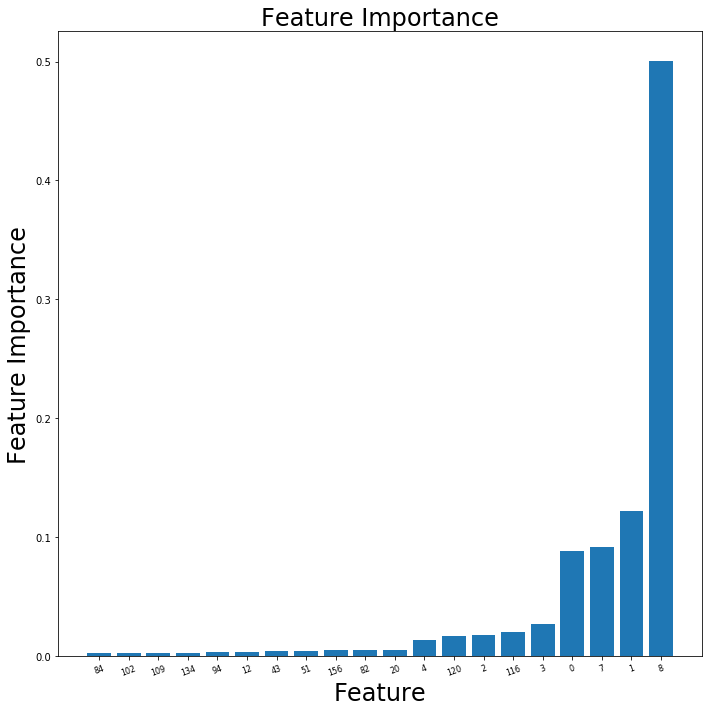

In [127]:
num_features = 10 
indices = np.argsort(importances)
indices2 = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')

# only plot the customized number of features
plt.bar(range(158,178), importances.toArray()[indices][158:178])
# Add feature names as x-axis labels
plt.xticks(range(158,178), feature_list[indices2][158:178], rotation=20, fontsize = 8)
# Create plot title
plt.title("Feature Importance",size=24)
plt.xlabel('Feature',size=24)
plt.ylabel('Feature Importance',size=24)
plt.tight_layout()
#plt.savefig('./churn_rf_featimp.jpeg')
# Show plot
plt.show()

# The three most important features are: 

In [129]:
train_data.columns[8],train_data.columns[1],train_data.columns[7]

('userAgent', 'itemInSession', 'ts')

# OneVsRest

In [155]:


lr =  LogisticRegression(featuresCol='features',labelCol='churn',maxIter=2)#, regParam=0.0, elasticNetParam=0)
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.05, 0.15))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .build()
#                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
#                              .addGrid(lr.maxIter, (5, 10))\
#                              .addGrid(lr.tol, (1e-4, 1e-5))\
#pipeline = Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,lr])
#pipeline = Pipeline(stages=[lr])

ovr=OneVsRest(classifier=lr,labelCol='churn')

pipeline=Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,ovr])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',metricName="f1"),
#                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',predictionCol='prediction'),
                    numFolds=4)


In [156]:
ORModel=cv.fit(train_data)

In [157]:
ORModel.avgMetrics

[0.9879663729878019,
 0.9879663729878019,
 0.9879663729878019,
 0.9879663729878019,
 0.9879663729878019,
 0.9879663729878019,
 0.9879663729878019,
 0.9879663729878019]

In [158]:
results = ORModel.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='churn',predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

F1 Score:0.988297408226171


# SVM

In [189]:
lsvc = LinearSVC(maxIter=10, regParam=0.1,labelCol='churn')
paramGrid = ParamGridBuilder().addGrid(lsvc.regParam,(0.05,0.1,0.2))\
                              .build()
#                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
#                              .addGrid(lr.maxIter, (5, 10))\
#                              .addGrid(lr.tol, (1e-4, 1e-5))\
#pipeline = Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,lr])
#pipeline = Pipeline(stages=[lr])

pipeline=Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,lsvc])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',metricName="f1"),
#                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',predictionCol='prediction'),
                    numFolds=4)


In [190]:
SVMModel=cv.fit(train_data)

In [192]:
SVMModel.avgMetrics

[0.9815115990880587, 0.9879663729878019, 0.9750332905646739]

In [193]:
results = SVMModel.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='churn',predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

F1 Score:0.988297408226171


# GBTClassifier

In [205]:
gbt = GBTClassifier(labelCol="churn", featuresCol="features", maxIter=10)


In [208]:
paramGrid = ParamGridBuilder() \
    .build()
#    .addGrid(gbt.numFolds, [50,100]) \
#    .addGrid(gbt.MaxDepth, [12,15]) \
#    .addGrid(rf.maxDepth, [3,6,9]) \
#    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
#    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
#                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
#                              .addGrid(lr.maxIter, (5, 10))\
#                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
#                              .addGrid(lr.maxIter, (5, 10))\
#                              .addGrid(lr.tol, (1e-4, 1e-5))\
#pipeline = Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,lr])
#pipeline = Pipeline(stages=[lr])

pipeline=Pipeline(stages=[stringInd_gender,encoder_gender,stringInd_level,encoder_level,stringInd_method,encoder_method,stringInd_location,encoder_location,stringInd_Agent,encoder_Agent,vec_assem,gbt])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',metricName="f1"),
#                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',predictionCol='prediction'),
                    numFolds=4)


In [209]:
GBTModel=cv.fit(train_data)

In [210]:
GBTModel.avgMetrics

[0.9879928420748159]

In [211]:
results = GBTModel.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='churn',predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

F1 Score:0.988297408226171


# Summarizing the results in a DataFrame

In [103]:
results_df=pd.DataFrame([0.98829,0.0,0.98829,0.98829,0.98829,0.98799],index=['LR','LReg','RF','OVR','SVM','GBT'],columns=['f1-score'])

In [104]:
results_df

,f1-score
LR,0.98829
LReg,0.00000
RF,0.98829
OVR,0.98829
SVM,0.98829
GBT,0.98799


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.